(chap-raeumliche-operationen)=
# Aufgabe 14: GIS in Python

## Theorie

Was bringt uns diese *Geo* Erweiterung? Mit *GeoDataFrames* sind nun alle räumliche Operationen möglich, die wir bereits aus ArcGIS kennen aber mit einfachen *DataFrames* noch nicht möglich waren. Ich möchte dies an ein paar Beispielen Demonstrieren. Dazu müssen wir die Zeckenstiche in GeoDataFrame konvertiert und in einGeopackage exportiert haben, wie in {ref}`chap-pythongis` beschrieben.

In [1]:
import geopandas as gpd

zeckenstiche = gpd.read_file("data/zeckenstiche.gpkg")

````{admonition} Wichtig
:class: attention
:name: gpd-conversion

- Die verschiedenen räumlichen Operationen in Geopandas erwarten unterschiedlichen Input, deshalb müssen wir manchmal zwischen *Geometrien*, *Geoseries* und *GeoDataFrames* hin- und her konvertieren (siehe {ref}`chap-pythongis-datenstruktur`). 
- Welcher Datentyp eure Operation *braucht* seht ihr in [der Dokumentation](https://geopandas.org/). Welcher Datentyp ihr *habt* seht ihr mit `type()`.
- Um ein Objekt von einem Format in das andere zu konvertieren (angenommen das Objekt heisst `x`)

```python
zecken_geoseries = gpd.GeoSeries(zeckenstiche["geometry"])          # von GeoDataFrame zu Geoseries
zecken_geodataframe = gpd.GeoDataFrame(geometry = zecken_geoseries) # von GeoSeries zurück zu GeoDataFrame
```
````

### Buffer

Eine typische GIS Operation ist das "Buffern" von Objekten. Der ArcGIS Befehl ["Buffer"](https://pro.arcgis.com/en/pro-app/tool-reference/analysis/buffer.htm) erreichen wir in Geopandas mit `.buffer()`. Folgender Code macht einen Buffer mit einer Distanz von 10m. 

In [2]:
buffered = zeckenstiche.buffer(10) 

Um Geopandas-Objekte zu plotten kann man einfach `.plot()` verwenden. Zudem kann man mit `boundary` die Umrisse eines Polygons extrahieren:

<AxesSubplot:>

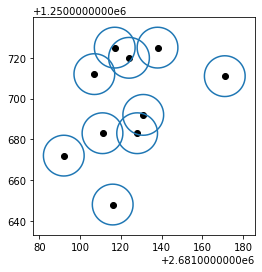

In [3]:
base = buffered.boundary.plot() # plottet die boundries    

zeckenstiche.plot(ax = base, color = "black") # plottet die Punkte

### Union

Mit `unary_union` können wir aus unserer *Point*-Geometrie ein *MultiPoint* erstellen (siehe {ref}`chap-pythongis-datenstruktur`). Dieser Befehl lautet in ArcGIS [Union](https://desktop.arcgis.com/de/arcmap/10.3/tools/analysis-toolbox/union.htm).

In [4]:
zeckenstiche_union = zeckenstiche["geometry"].unary_union

type(zeckenstiche_union) # Es handelt sich nun um den Typ "MultiPoint"

shapely.geometry.multipoint.MultiPoint

Wenn wir uns `zeckenstiche_union` nun mit `print` anschauen sehen wir, dass sämtliche Koordinaten in einem Objekt zusammengepackt sind: 

In [5]:
print(zeckenstiche_union)

MULTIPOINT (2681092 1250672, 2681107 1250712, 2681111 1250683, 2681116 1250648, 2681117 1250725, 2681124 1250720, 2681128 1250683, 2681131 1250692, 2681138 1250725, 2681171 1250711)


(chap-raeumliche-operationen-mbg)=
### Minimum Bounding Geometry

Über ein *MultiPoint* lassen sich jetzt wunderbar sogenannte (in ESRI Terminologie) [Minimum Bounding Geometries](https://pro.arcgis.com/de/pro-app/tool-reference/data-management/minimum-bounding-geometry.htm) rechnen. Mit den gleichnamigen Funktionen können wir nun eine `convex_hull` [^convex-hull] sowie eine `envelope` [^envelope] über alle Punkte rechnen.

[^convex-hull]:  Convex Hull stellt ein "Rahmen" um alle Punkte dar, wo alle Innenwinkel kleiner sind als 180° (*konvex*)
[^envelope]: Envelope stellt ebenfalls ein "Rahmen um alle Punkte dar, die aber quadratisch geformt und am Koordiatensystem ausgerichtet ist.



In [6]:
my_convex_hull = zeckenstiche_union.convex_hull
my_envelope = zeckenstiche_union.envelope

Nun konvertiere ich beide Polygon-Geometrien in *GeoSeries*, damit sie einfacher zu visualisieren sind:

In [7]:
my_convex_hull = gpd.GeoSeries(my_convex_hull)
my_envelope = gpd.GeoSeries(my_envelope)

Um die beiden Objekte nebeneinander zu visualisieren importiere ich zuerst `pyplot` aus `matplotlib` (mit dem alias `plt`) und erstelle `subplots`

<AxesSubplot:title={'center':'Envelope'}>

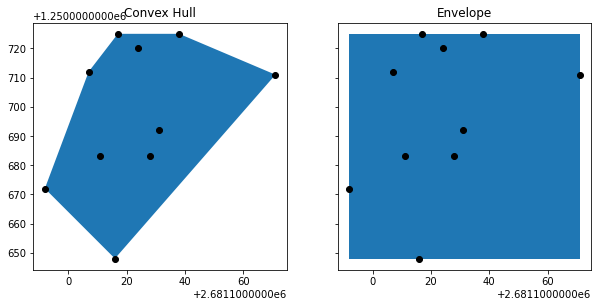

In [8]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True, sharey = True,figsize = (10,10))

# Erstellt den linken Plot
my_convex_hull.plot(ax = ax1)
ax1.set_title("Convex Hull")
zeckenstiche.plot(ax = ax1, color = "black")

# Erstellt den rechten Plot
my_envelope.plot(ax = ax2)
ax2.set_title("Envelope")
zeckenstiche.plot(ax = ax2, color = "black")

### Overlay

Viele der Funktionen aus dem ESRI Toolset ["Overlay"](https://pro.arcgis.com/de/pro-app/tool-reference/analysis/an-overview-of-the-overlay-toolset.htm) sind in der *Geopandas* Funktion `overlay` verpackt. Um sie zu demonstrieren nutze ich die Geometrien, die wir in weiter oben erstellt haben (`buffered` und `my_convex_hull`). Zuerst muss ich sie aber noch von *GeoSeries* in *GeoDataFrames* konverieren.

In [9]:
buffered_gdf = gpd.GeoDataFrame(geometry = buffered, crs = 2056)               
my_convex_hull_gdf = gpd.GeoDataFrame(geometry = my_convex_hull, crs = 2056) 

Nun kann ich zum beispielsweise die Overlay-Funktion `difference` ausführen:

In [10]:
my_difference = gpd.overlay(my_convex_hull_gdf,buffered_gdf, how='difference')

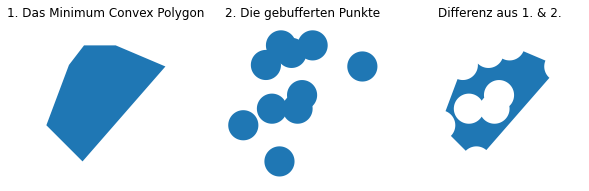

In [11]:
# Bereitet die drei Subplots vor ################
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey = True, figsize = (10,10))
#################################################

# Plot links ####################################
my_convex_hull_gdf.plot(ax = ax1)               #
ax1.set_title("1. Das Minimum Convex Polygon")  # 
ax1.set_axis_off()                              #
# Plot mitte ####################################
buffered_gdf.plot(ax = ax2)                     #
ax2.set_title("2. Die gebufferten Punkte")      # 
ax2.set_axis_off()                              #
# Plot rechts ###################################
my_difference.plot(ax = ax3)                    #
ax3.set_title("Differenz aus 1. & 2.")          # 
ax3.set_axis_off()                              #
#################################################

## Übungen

Nun ist es Zeit, dass ihr selbst mit *GeoDataFrames* Hand anlegt. Achtet dabei immer auf die Datentypen eurer Daten (mit `type`) und konsultiert dazu {ref}`chap-pythongis-datenstruktur`. Zudem ist Geopandas gut dokumentiert, es lohnt ich diese immer wieder zu konsultieren: [geopandas.org](https://geopandas.org)

% *DataFrame* zu *GeoDataFrame*
### Übung 14.1

Importiere *Geopandas* und wandle `zeckenstiche` in eine *GeoDataFrame* um (`zeckenstiche`). Vergiss nicht, das Koordinatenbezugssystem festzulegen!

In [12]:
# Musterlösung

import geopandas as gpd

zeckenstiche = gpd.GeoDataFrame(zeckenstiche, geometry=gpd.points_from_xy(zeckenstiche['x'], zeckenstiche['y'], crs = 2056))

% Punkte Buffern
### Übung 14.2

Buffere die Zeckenstiche um eine Distanz von 12 Meter und speichere den Output in der Variabel `zeckenstiche_buffer`. Visualisiere die gebufferten Punkte mit `.explore()`.

In [43]:
# Musterlösung

zeckenstiche_buffer = zeckenstiche.buffer(12)
zeckenstiche_buffer.explore()

% : Umrisse visualisieren
### Übung 14.3

Extrahiere die Umrisse von `zeckenstiche_buffer` und speichere diese in `zeckenstiche_buffer_outline`. Visualisiere anschliessend diese Umrisse.

In [44]:
# Musterlösung

zeckenstiche_buffer_outline = zeckenstiche_buffer.boundary

zeckenstiche_buffer_outline.explore()

% : Layers überlagern
### Übung 14.4

Nutze nachstehenden Code um zwei Datensätze im gleichen Plot darzustellen. 

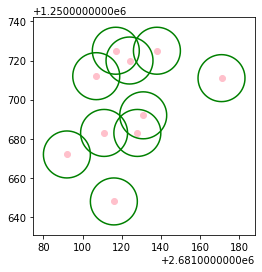

In [46]:
# Nicht interaktiv:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

zeckenstiche_buffer_outline.plot(ax = ax, color = "green")
zeckenstiche.plot(ax = ax, color = "pink")


In [48]:

# Interaktiv:

base = zeckenstiche_buffer_outline.explore(color = "green")
zeckenstiche.explore(m = base, color = "pink")




% Envelope
### Übung 14.5

Berechne das "Envelope" von `zeckenstiche` anhand der obigen Beispielen. Speichere den Output als `zeckenstiche_envelope`.

```{tip}
:class: dropdown
Denk daran, dass du zuerst noch einen Union machen musst (siehe [diese Notiz](gpd-conversion))
```


In [49]:
# Musterlösung

zeckenstiche_envelope = zeckenstiche.unary_union.envelope

### Übung 14.6

Exportiere `zeckenstiche` als "Geopackage" mit dem Namen "zeckenstiche.gpkg". Lese nochmal {ref}`chap-pythongis-formate` wenn du nicht mehr weisst, wie das geht. Versuche anschliessend, "zeckenstiche.gpgk" wieder einzulesen.

```python
# Musterlösung

zeckenstiche.to_file("data/zeckenstiche.gpkg")
```